In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import random
from scipy.stats import bernoulli

from exchange import *
from agents import *
from simulation import *

# Define MainCharacter Policy

In [2]:
def execute_policy(e: Exchange, price_function, policy_number: int):
    # main character params: true_value, quantity, side, spread, cid

    if list(e.bids.keys()) != [] and list(e.asks.keys()) != []:
        tob_bid = max(e.bids.keys())
        tob_ask = min(e.asks.keys())
    else: 
        return
    current_true_value = price_function(e.get_timestamp())

    policies = []

    ### quote 6 wide around 100 ###
    policies.append(MainCharacter(true_value=100, quantity=10, side="AB", spread=3, cid=-1.5))

    ### quote 2 wide around 100 ### 
    policies.append(MainCharacter(true_value=100, quantity=10, side="AB", spread=1, cid=-2.5))

    ### quote 2 wide around 100, quantity 1 ###
    policies.append(MainCharacter(true_value=100, quantity=1, side="AB", spread=1, cid=-3.5))

    ### quote 2 wide around true val (perfect information) ###
    policies.append(MainCharacter(true_value = price_function(e.get_timestamp()), quantity=5, side="AB", spread=1, cid=-4.5))

    ### quote 2 wide around true val 10 timestamps ago ### 
    policies.append(MainCharacter(true_value=price_function(e.get_timestamp() - 10), quantity=5, side="AB", spread=1, cid=-5.5))

    ### quote 2 wide around true value 10 timestamps into future ###
    policies.append(MainCharacter(true_value=price_function(e.get_timestamp() + 10), quantity=5, side="AB", spread=1, cid=-6.5))

    ### quote 6 wide around true value  ###
    policies.append(MainCharacter(true_value=price_function(e.get_timestamp() + 10), quantity=5, side="AB", spread=3, cid=-7.5))

    ### psychic far looking wide policy ###
    policies.append(MainCharacter(true_value=price_function(e.get_timestamp() + 50), quantity=5, side="AB", spread=3, cid=-8.5))

    a = policies[policy_number]

    if policy_number <= 7:
        if a.cid not in list(e.ask_customers.keys()) and a.cid not in list(e.bid_customers.keys()):
            e.add_order(a)
        return

    ### quote 1 ticks from top of book ### 
    if policy_number == 8:
        b = MainCharacter(true_value=tob_bid, quantity=5, side="B", spread=1, cid=-9.5)
        a = MainCharacter(true_value=tob_ask, quantity=5, side="A", spread=1, cid=-9.5)
        if a.cid not in list(e.ask_customers.keys()):
            e.add_order(a)
        if b.cid not in list(e.bid_customers.keys()):
            e.add_order(b)

    #TODO: this seems bugged
    ### long-short taking strategy ###
    if policy_number == 9:
        if tob_ask < current_true_value:
            b = MainCharacter(true_value=tob_ask, quantity=min(10, e.asks[tob_ask]), side="B", spread=0, cid=-10.5)
            e.add_order(b)
        if tob_bid > current_true_value:
            a = MainCharacter(true_value=tob_bid, quantity=min(10, e.bids[tob_bid]), side="A", spread=0, cid=-10.5)
            e.add_order(a)

# Define Price Function

In [3]:
### constant price ###
# price_function = lambda t: 100

### linear price ###
# price_function = lambda t: 0.001*t + 100

### sine fluctuating ###
# price_function = lambda t: np.sin(t / 500) * 10 + 100

### exponential ###
# price_function = lambda t: t * np.exp(t / 10000) + 100

Text(0.5, 0, 'timestamp')

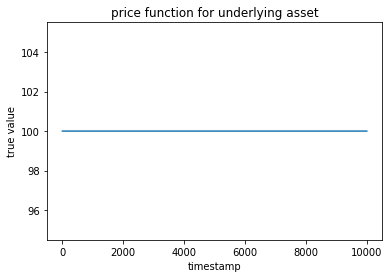

In [4]:
times = range(10000)
plt.plot([price_function(t) for t in times])
plt.title("price function for underlying asset")
plt.ylabel("true value")
plt.xlabel("timestamp")

# Run Simulation

### Linear Price Function

In [46]:
%%capture

price_function = lambda t: 100

policy_data = []
for policy_num in range(8):
    profits = []
    ranks = []
    exchanges = []
    summaries = []

    for iteration in range(20): # run 10 simulations
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=0.1, taker_probability=0.4, n=100000)
        summary, profit = summarize_transactions(e, price_function, num_agents=20)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0 
            rank = None
        else: 
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)

    policy_data.append((profits, ranks, exchanges, summaries))

In [47]:
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]

[354.2, 5373.9, 1080.8, 3641.5, 3660.95, 3605.1, 295.65, 321.7]

In [49]:
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.45, 1.15]

## Linear Price Function

In [51]:
%%capture

price_function = lambda t: 0.001*t + 100

policy_data = []
for policy_num in range(8):
    profits = []
    ranks = []
    exchanges = []
    summaries = []

    for iteration in range(20): # run 10 simulations
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=0.1, taker_probability=0.4, n=100000)
        summary, profit = summarize_transactions(e, price_function, num_agents=20)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0 
            rank = None
        else: 
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)

    policy_data.append((profits, ranks, exchanges, summaries))
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

In [52]:
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]

[-186572.3954506645,
 -192437.09657368585,
 -19259.56625906219,
 4180.796352725414,
 4917.268490290521,
 4392.296117690648,
 -204.06412147687047,
 770.8677835720234]

In [53]:
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

[21.0, 21.0, 21.0, 4.0, 3.25, 3.6, 11.5, 8.8]

## Sine Price Function

In [54]:
%%capture

price_function = lambda t: np.sin(t / 500) * 10 + 100

policy_data = []
for policy_num in range(8):
    profits = []
    ranks = []
    exchanges = []
    summaries = []

    for iteration in range(20): # run 10 simulations
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=0.1, taker_probability=0.4, n=100000)
        summary, profit = summarize_transactions(e, price_function, num_agents=20)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0 
            rank = None
        else: 
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)

    policy_data.append((profits, ranks, exchanges, summaries))
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

In [55]:
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]

[9747.194688442489,
 6148.274651557542,
 673.8184190494035,
 1150.3300414527773,
 1158.4746149092548,
 1021.6048162004463,
 778.8282858233193,
 268.3965249624733]

In [56]:
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

[1.0, 1.0, 3.3, 2.05, 2.25, 2.7, 4.1, 8.3]

## Exponential Price Function

In [57]:
%%capture

price_function = lambda t: t * np.exp(t / 10000) + 100

policy_data = []
for policy_num in range(8):
    profits = []
    ranks = []
    exchanges = []
    summaries = []

    for iteration in range(20): # run 10 simulations
        e = simulate(price_function, execute_policy, policy_number=policy_num, agent_arrival_rate=0.1, taker_probability=0.4, n=100000)
        summary, profit = summarize_transactions(e, price_function, num_agents=20)
        summaries.append(summary)
        exchanges.append(e)

        if len(profit[profit.index % 1 == 0.5]) == 0:
            p = 0 
            rank = None
        else: 
            p = profit[profit.index % 1 == 0.5].iloc[0, -1]
            rank = list(profit.index % 1).index(0.5) + 1
        profits.append(p)
        ranks.append(rank)

    policy_data.append((profits, ranks, exchanges, summaries))
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

In [58]:
# average profit for each simple policy
[np.mean(arr[0]) for arr in policy_data]

[-629071720856.7079,
 -703955893315.9158,
 -92270618453.07802,
 -110805064792.34229,
 -254455499232.09604,
 -72965454515.67749,
 -81440425045.16817,
 -4601431623.409572]

In [59]:
# average rank for each simple policy
[np.mean(arr[1]) for arr in policy_data]

[21.0, 21.0, 17.15, 17.7, 20.8, 15.6, 16.15, 11.25]

In [ ]:
##TODO: 

''' 
- for each price function, determine best policy
- demonstrate average arrival rate by looking at underlying exchange objects
- track something like average order duration (for orders that get hit)
- track balance between taker ratio and maker ratio for trades that occur (across different price functions)
- determine: under what conditions do trades usually happen?
- 
''' 